# Background:
Reproduce the results in Ref: Physics-informed echo state networks (Doan, 2020)


# Imports:

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

# System:

### Lorenz iterator:

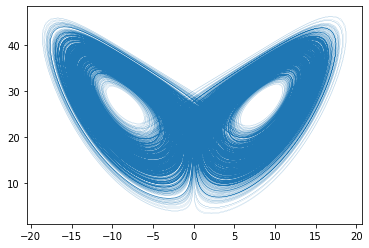

In [2]:
# Lorenz parameters:
dt_L = 0.01
starting_point_L = np.array([0, 1, 0])

# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 100000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series = time_series_all[disc_steps:, :]

plt.plot(time_series[:, 0], time_series[:, 2], linewidth=0.1)

# RC prediction:

In [23]:
train_steps = 2000
sync_steps = 300

# create network:
esn = rescomp.ESNWrapper()

np.random.seed(42)
esn.create_network(n_dim=500, n_rad=0.1, n_avg_deg=6.0,
                    n_type_flag="erdos_renyi", network_creation_attempts=10)

x_dim = time_series.shape[1]
esn.create_input_matrix(x_dim, w_in_scale=1.0, w_in_sparse=True, w_in_ordered=False)

# train and predict:
y_pred, y_test = esn.train_and_predict(time_series, train_sync_steps=sync_steps, train_steps=train_steps,
                                       w_out_fit_flag="linear_and_square_r_alt")

# Compare real vs. predicted time_series:

In [20]:
time = np.arange(0, y_pred.shape[0])*dt_L

## small times:

(0, 15)

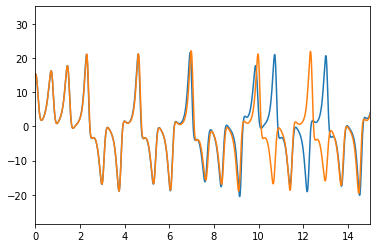

In [24]:
# Simple: plot some coordinates
ix = 1
plt.plot(time, y_test[:, ix])
plt.plot(time, y_pred[:, ix])

plt.xlim(0, 15)

(0, 15)

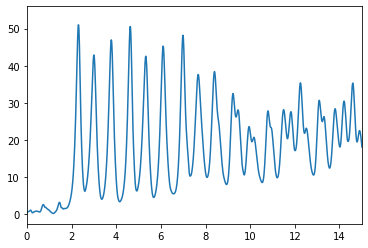

In [22]:
# plot the error over time:
error = rescomp.measures.error_over_time(y_pred, y_test)
plt.plot(time, error)
plt.xlim(0, 15)

## Attractor measures:

### Probability Density Function:

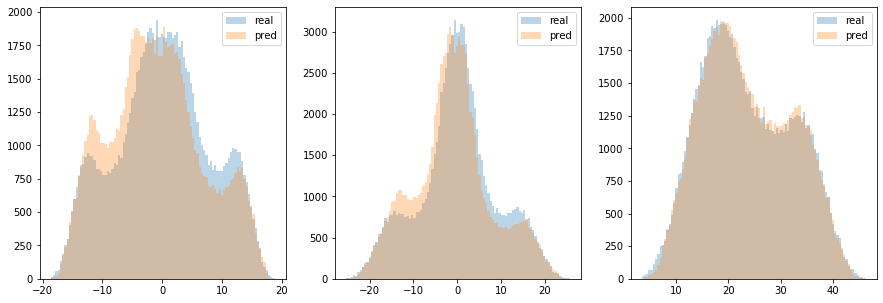

In [10]:
# PDE:
plt.figure(figsize=(15,5))

plt.subplot(131)
ix = 0

_, b, _ = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(132)
ix = 1
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(133)
ix = 2
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

### Fourier Spectrum:

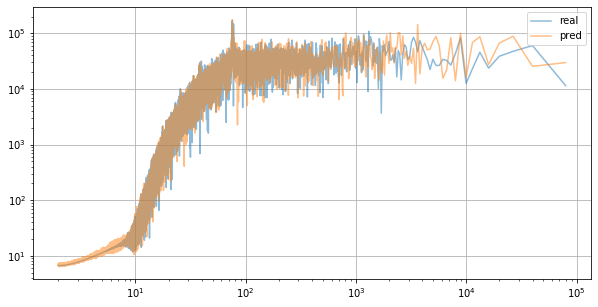

In [9]:
# Fourier Spectrum:
plt.figure(figsize=(10, 5))

x, y = rescomp.measures.fourier_spectrum(y_test, period=True)
plt.plot(x,y, label="real", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(y_pred, period=True)
plt.plot(x,y, label="pred", alpha=0.5)

# plt.xlim(-0.01, 0.02)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend()

### Poincare Map:

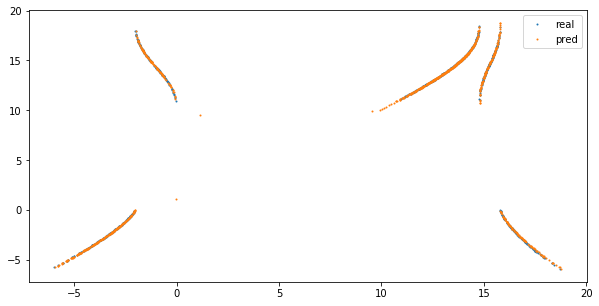

In [10]:
# Poincare Map:
ix = 0
mode="maxima"

plt.figure(figsize=(10, 5))

x, y = rescomp.measures.poincare_map(y_test, dimension=ix, mode=mode)
plt.scatter(x, y, label="real", s=1)

x, y = rescomp.measures.poincare_map(y_pred, dimension=ix, mode=mode)
plt.scatter(x, y, label="pred", s=1)

plt.legend()

### Correlation Dimension:

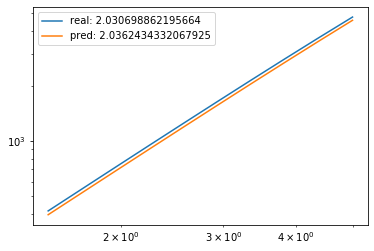

In [11]:
sloap, N_r = rescomp.measures.dimension(y_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"pred: {sloap}")

plt.legend()

### Lyapunov spectrum:

#### Rosenberg Algorithm:

avg period: 3.628044383186562
For 0/79700 points, all 50 closest neighbours were temporally closer than 3.628044383186562 and thus not considered
For 888/79700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 78812
avg period: 4.260265365622095
For 0/79700 points, all 50 closest neighbours were temporally closer than 4.260265365622095 and thus not considered
For 1095/79700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 78605


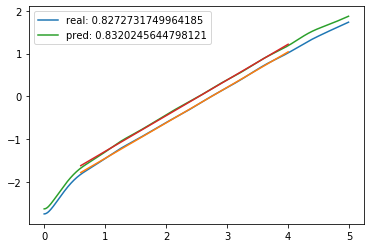

In [12]:
t_min, t_max = 0.6, 4
steps = 500

out = rescomp.measures.lyapunov_rosenstein(y_test, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"real: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(y_pred, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"pred: {coef[0]}")
plt.plot(x_fit, y_fit)

plt.legend()

#### QR decomposition:

In [202]:
Nens = 5
N_dims = 5
np.random.seed(42)
starting_points = np.random.randn(Nens, 3)

In [14]:
# iterator of reservoir:
def f_res(x):
    return esn._predict_step(x)

In [204]:
out_real = rescomp.measures.calculate_divergence(f_L, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

out_res = rescomp.measures.calculate_divergence(f_res, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000
N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000


(0, 1)

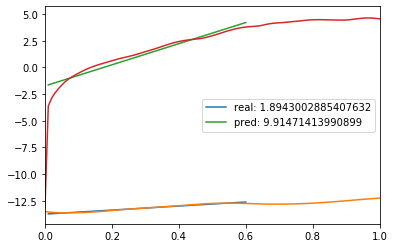

In [206]:
for out, label in zip((out_real, out_res), ("real", "pred")):
    y = np.log(out)
    y = np.mean(y, axis=-1)[:, 0]
    t = np.arange(0, y.size)*dt_L
    x_fit, y_fit, coef = rescomp.utilities._linear_fit(y, dt_L, t_min=0.01, t_max=0.6)
    plt.plot(x_fit, y_fit, label=f"{label}: {coef[0]}")
    plt.plot(t, y)
plt.legend()
plt.xlim(0, 1)

## Different inputs and synchronization:

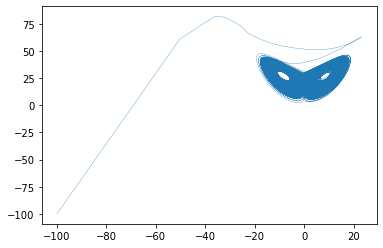

In [15]:
starting_point = np.array([-100, -100, -100])

# test lorenz iterator:
time_steps = 100000

time_series_2 = np.zeros((time_steps, 3))
time_series_2[0, :] = starting_point

res_results = np.zeros((time_steps, 500))

for i in range(1, time_steps):
    x_last = time_series_2[i - 1, :]
    time_series_2[i, :] = f_res(x_last)
    res_results[i, :] = esn._last_r

plt.plot(time_series_2[:, 0], time_series_2[:, 2], linewidth=0.3)

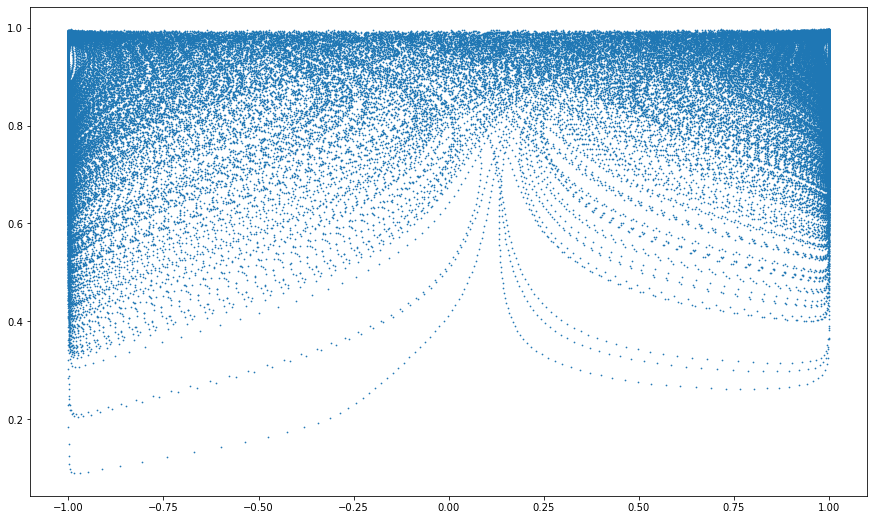

In [25]:
plt.figure(figsize=(15, 9))
# plt.plot(res_results[:, 5])
# plt.plot(res_results[1000:-1000, 50], res_results[1000:-1000, 76], linewidth=0.3)
plt.scatter(res_results[1000:-1000, 53], res_results[1000:-1000, 52], s=0.5)

### PCA on reservoir states:

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(res_results)
X = pca.transform(res_results)
print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.89430941 0.09141061 0.00928027]
[4661.74817278 1490.4013046   474.88143114]


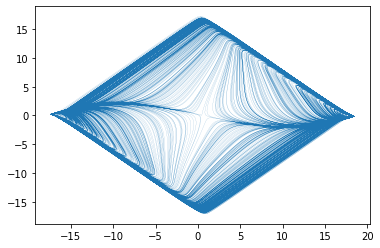

In [29]:
plt.plot(X[1000:, 0], X[1000:, 1], linewidth=0.1)

In [ ]:
# sloap, N_r = rescomp.measures.dimension(X[1000:, :], return_neighbours=True, nr_steps=10)
sloap, N_r = rescomp.measures.dimension(res_results, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

plt.legend()

# Lorenz 96 Iterator:

### Plotting the pure Lorenz 96 system

In [13]:
# Lorenz 96 parameters:
dt_L96 = 0.01
dims_L96 = 60
np.random.seed(1)
starting_point_L96 = np.random.randn(dims_L96)

In [14]:
# Lorenz96 iterator:

_lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta
f_L96 = lambda x: iterator(_lorenz_96, dt_L96, x)

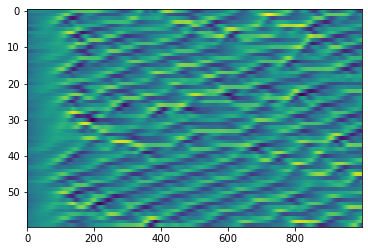

In [15]:
time_steps_L96 = 1000
results_L96 = np.zeros((time_steps_L96, dims_L96))

results_L96[0, :] = starting_point_L96
for i in range(1, time_steps_L96):
    x_last = results_L96[i - 1, :]
    results_L96[i, :] = f_L96(x_last)

plt.imshow(results_L96.T, aspect="auto")

# Reservoir:

In [180]:
import tensorflow as tf
from keras.layers import AveragePooling1D, Conv1D, InputLayer
from keras.models import Sequential
import networkx as nx

np.random.seed(2)

# Parameters:
time_steps = 10000
disc_timesteps = 100

# reservoir:
dims = [1000, 800, 500]
convs = [dims_L96, int(dims_L96 / 2), int(dims_L96/4)]
print(convs)

model1 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=1, strides=1, padding='same')
])
def f1(x):
    return model1.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96))

model2 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=2, strides=2, padding='same')
])
def f2(x):
    return model2.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/2))

model3 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=4, strides=4, padding='same')
])
def f3(x):
    return model3.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/4))

pools = [f1, f2, f3]

w_in_scale = 0.5
w_ins = []
for i in range(3):
    w_in = np.random.uniform(low=-w_in_scale,
                             high=w_in_scale,
                             size=(dims[i], convs[i]))
    w_ins.append(w_in)

edge_prob = 0.01
Ws = []
for i in range(3):
    W = nx.to_numpy_array(nx.fast_gnp_random_graph(dims[i], edge_prob,seed=np.random))
    Ws.append(W)

res_states = []
for i in range(3):
    res_state = np.zeros((time_steps, dims[i]))
    res_state[0, :] = np.random.randn(dims[i])
    res_states.append(res_state)

[60, 30, 15]


In [181]:
starting_point_L96_use = starting_point_L96
starting_point_L_use = starting_point_L

# discard the starting timesteps:
for i in range(disc_timesteps):
    starting_point_L96_use = f_L96(starting_point_L96_use)
    starting_point_L_use = f_L(starting_point_L_use)

In [182]:
# L96
results_L96 = np.zeros((time_steps, dims_L96))
results_L96[0, :] = starting_point_L96_use

# L:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = starting_point_L_use

##  Run RC:

In [183]:
# f = lambda x: np.tanh(x)
# f = lambda x: 0.1*x
# f = lambda x: np.heaviside(x,1)
f = lambda x: 1/(1+np.exp(-x))

for i in range(1, time_steps):
    x_last_in = results_L96[i - 1, :]

    x_last_res1 = res_states[0][i - 1, :]
    x_last_res2 = res_states[1][i - 1, :]
    x_last_res3 = res_states[2][i - 1, :]

    for k in range(3):
        x_last_res =  res_states[k][i - 1, :]

        # apply pooling:
        x_last_in_pool = pools[k](x_last_in)
        # print(x_last_in_pool.shape)
        # print(w_ins[k].shape)
        # coupl pooled input with reservoir
        inp =  w_ins[k].dot(x_last_in_pool) + Ws[k].dot(x_last_res)
        res_states[k][i, :] = f(inp)
    results_L96[i, :] = f_L96(x_last_in)

## Plot Reservoir quantities:

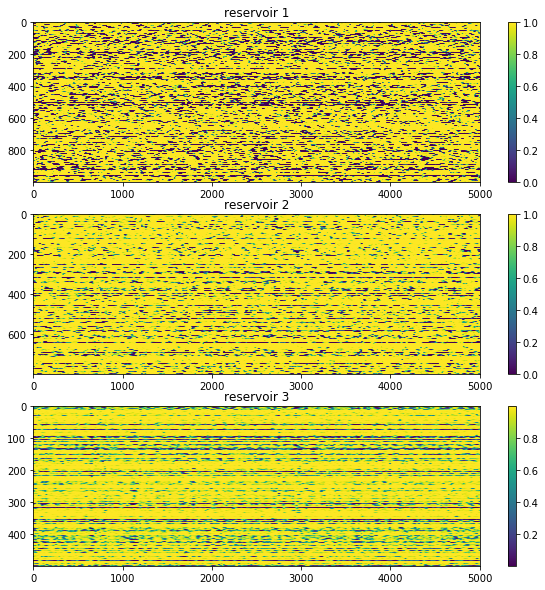

In [184]:
xlim = (0,5000)
# xlim = None

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for k in range(3):
    ax = axs[k]
    im = ax.imshow(res_states[k][1:, :].T, aspect="auto")
    ax.set_xlim(xlim)
    ax.set_title(f"reservoir {k+1}")
    fig.colorbar(im, ax=ax, orientation='vertical')

(0, 0.1)

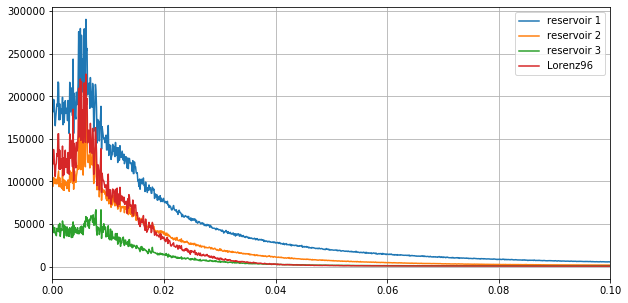

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for k in range(3):
    x, y = rescomp.measures.fourier_spectrum(res_states[k])
    ax.plot(x, y, label=f"reservoir {k+1}")


x, y = rescomp.measures.fourier_spectrum(results_L96)
ax.plot(x, y, label="Lorenz96")

ax.grid()
ax.legend()
ax.set_xlim(0, 0.1)

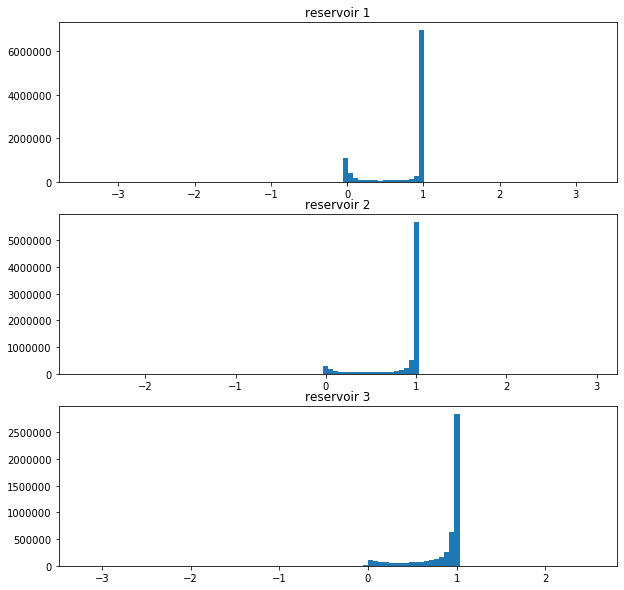

In [186]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for k in range(3):
    ax = axs[k]
    ax.hist(res_states[k].flatten(), bins=100)
    ax.set_title(f"reservoir {k+1}")

## Train and Test:

In [187]:
from sklearn.linear_model import Ridge, LogisticRegression
# Try to fit the coupled to the output:
sync_steps = 500
train_steps = 8000
test_steps = 1500


y_sync = results_L96[: sync_steps, :]

y_train = results_L96[sync_steps: sync_steps + train_steps, :]

y_test = results_L96[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

y_test_pred_list = []

for k in range(3):
    x_sync = res_states[k][: sync_steps, :]
    x_train = res_states[k][sync_steps: sync_steps + train_steps, :]
    x_test = res_states[k][sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
    # Train:
    model = Ridge(alpha=0.005)
    model.fit(x_train, y_train)

    y_test_pred = model.predict(x_test)
    y_test_pred_list.append(y_test_pred)

all_together = np.concatenate(res_states, axis=-1)
x_sync = all_together[: sync_steps, :]
x_train = all_together[sync_steps: sync_steps + train_steps, :]
x_test = all_together[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
# Train:
model = Ridge(alpha=0.005)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_test_pred_list.append(y_test_pred)

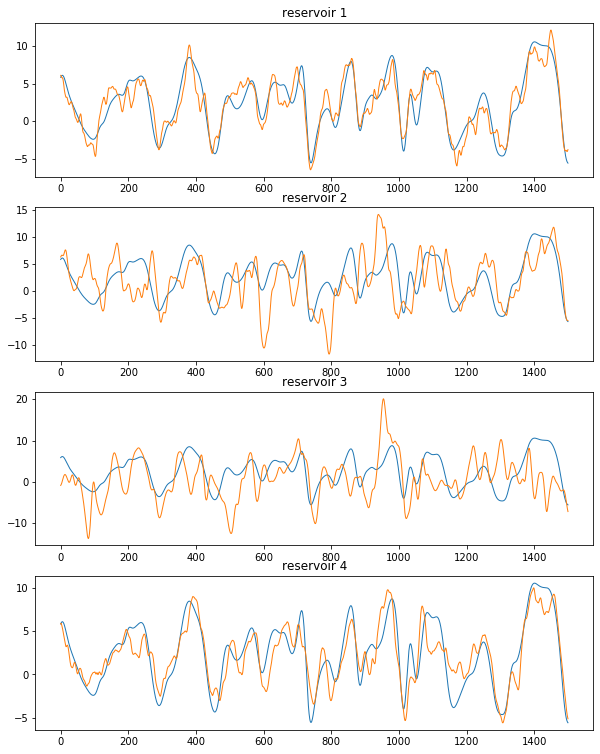

In [188]:
axis = 5

fig, axs = plt.subplots(4, 1, figsize=(10, 13))
for k in range(4):
    y_test_pred = y_test_pred_list[k]
    ax = axs[k]
    ax.plot(y_test[:, axis], linewidth=1)
    ax.plot(y_test_pred[:, axis], linewidth=1)
    ax.set_title(f"reservoir {k+1}")

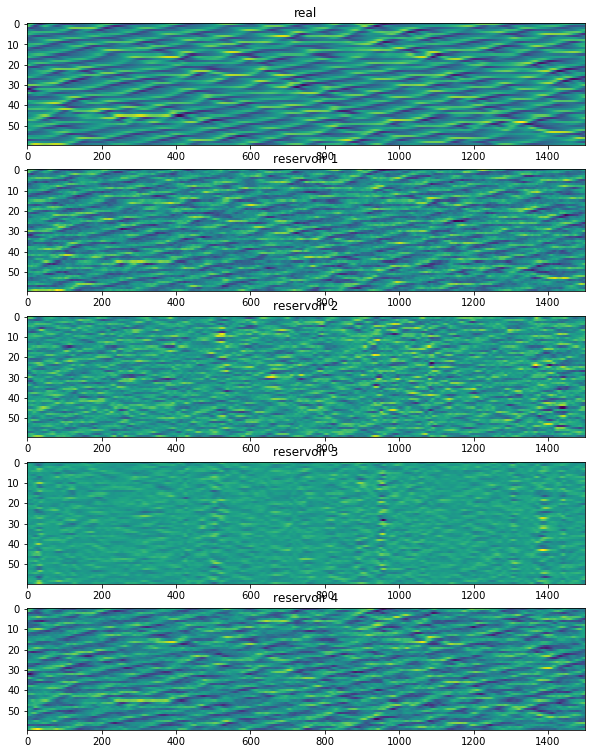

In [190]:
fig, axs = plt.subplots(5, 1, figsize=(10, 13))

axs[0].imshow(y_test.T, aspect="auto")
axs[0].set_title(f"real")

for k in range(0, 4):
    y_test_pred = y_test_pred_list[k]
    ax = axs[k+1]
    ax.imshow(y_test_pred.T, aspect="auto")
    ax.set_title(f"reservoir {k+1}")

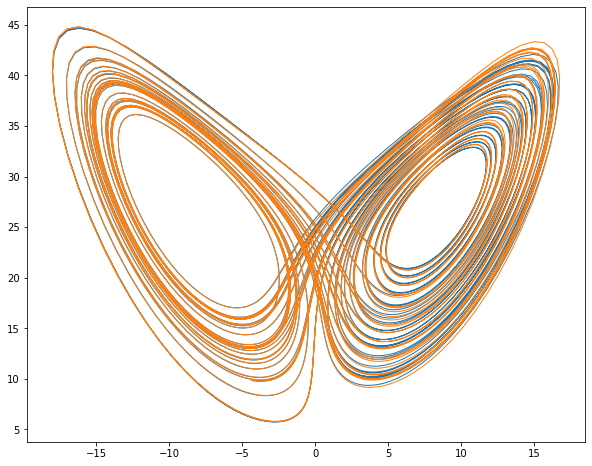

In [604]:
plt.figure(figsize=(10, 8))

plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1)
plt.plot(y_test_pred[:, 0], y_test_pred[:, 2], linewidth=1)

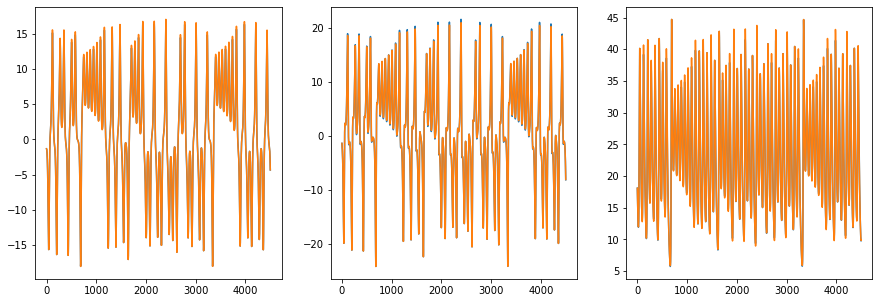

In [595]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axs[i]
    ax.plot(y_test[:, i])
    ax.plot(y_test_pred[:, i])

[0.71243533 0.19759869]
[499.71109667 263.17116446]


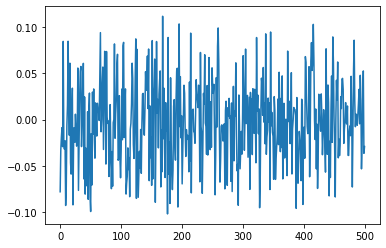

In [583]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(results_res)
# pca.fit(results_L96)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

pca1 = pca.components_[0]
plt.plot(pca1)

# KS iterator:


In [ ]:
dims = 200
L = 100

def data_creation_function_ks(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("kuramoto_sivashinsky_custom", dt, time_steps, starting_point, fft_type="scipy", dimensions=dims, system_size=L)

dt_ks = 0.5
def f_ks(x):
    return data_creation_function_ks(2, dt_ks, x)[-1]

In [ ]:
# test KS iterator:
time_steps = 1000
results_ks = np.zeros((time_steps, dims))

# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))

results_ks[0, :] = starting_point
for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    results_ks[i, :] = f_ks(x_last)

plt.imshow(results_ks.T, aspect="auto")

## Coupling of both systems:


In [0]:
w_in_scale = 0.0001
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))

In [0]:
# test KS iterator:
time_steps = 2000

# ks
results_ks = np.zeros((time_steps, dims))
# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))
results_ks[0, :] = starting_point

# lorenz:
time_series = np.zeros((time_steps, 3))
time_series[0, :] = np.array([0, 1, 0])

for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    x_last_in = time_series[i - 1, :]
    x_add = w_in.dot(x_last_in)
    # if i > 1000:
    #     x_add = 0
    results_ks[i, :] = f_ks(x_last + x_add)
    time_series[i, :] = f(x_last_in)
plt.imshow(results_ks.T, aspect="auto")

In [ ]:
plt.plot(time_series[:, 0], time_series[:, 1], linewidth=0.1)
